# Introduction - Titanic Linear Regression

Name: Gabriel Richards / gjrich

Date: 5 Apr 2025

This lab uses the Titanic dataset to review regression modeling techniques. Previous work focused on classification (predicting survival), but we'll now predict the fare passengers paid for their journey. We'll review how  passenger attributes like age, family size, and other features correlate with ticket pricing. We'll also build multiple regression models including Linear Regression, Ridge, Elastic Net, and Polynomial Regression, and evaluate their performance using R², RMSE, and MAE to determine which features and models best predict passenger fares.

## Python Package Imports

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import root_mean_squared_error


## Section 1. Import and Inspect the Data

Load the Titanic dataset and confirm it’s structured correctly.


Important: This code requires importing seaborn as sns and pandas. Our variable titanic holds a pandas DataFrame object. Know what imports are required for each bit of code. 

In [2]:
# Load Titanic dataset from seaborn and verify
titanic = sns.load_dataset("titanic")
titanic.head(20)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
5,0,3,male,NaN,0,0,8.4583,Q,Third,man,True,NaN,Queenstown,no,True
6,0,1,male,54.0,0,0,51.8625,S,First,man,True,E,Southampton,no,True
7,0,3,male,2.0,3,1,21.0750,S,Third,child,False,NaN,Southampton,no,False
8,1,3,female,27.0,0,2,11.1333,S,Third,woman,False,NaN,Southampton,yes,False
9,1,2,female,14.0,1,0,30.0708,C,Second,child,False,NaN,Cherbourg,yes,False


In [3]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [4]:
# Check for null/NaN values
null_count = titanic['embark_town'].isna().sum()
print(f"Number of null values in embark_town: {null_count}")

# Check for empty strings
empty_string_count = (titanic['embark_town'] == '').sum()
print(f"Number of empty strings in embark_town: {empty_string_count}")

# Check for whitespace-only strings
whitespace_count = (titanic['embark_town'].str.isspace()).sum()
print(f"Number of whitespace-only strings in embark_town: {whitespace_count}")

# Show rows with missing embark_town
missing_embark = titanic[titanic['embark_town'].isna()]
print("\nRows with missing embark_town:")
print(missing_embark[['survived', 'pclass', 'sex', 'age', 'fare']])

Number of null values in embark_town: 2
Number of empty strings in embark_town: 0
Number of whitespace-only strings in embark_town: 0

Rows with missing embark_town:
     survived  pclass     sex   age  fare
61          1       1  female  38.0  80.0
829         1       1  female  62.0  80.0


## Section 2. Data Exploration and Preparation

Prepare the Titanic data for regression modeling. See the previous work.

- Impute missing values for age using median
- Drop rows with missing fare (or impute if preferred)
- Create numeric variables (e.g., family_size from sibsp + parch + 1)
- Optional - convert categorical features (e.g. sex, embarked) if you think they might help your prediction model. (We do not know relationships until we evaluate things.)

In [5]:
# Calculate the mean and standard deviation of known ages
age_mean = titanic['age'].mean()
age_std = titanic['age'].std()

# Count missing values
age_null_count = titanic['age'].isnull().sum()

# Generate random ages from normal distribution 
np.random.seed(307)  # For reproducibility
age_random_values = np.random.normal(age_mean, age_std, age_null_count)

# Apply age boundary constraints (0 to 85 years)
age_random_values = np.clip(age_random_values, 0, 85)

# Round ages to whole numbers
age_random_values = np.round(age_random_values)

# Create a mask for rows with missing age
age_null_mask = titanic['age'].isnull()

# Fill missing values with the random ages
titanic.loc[age_null_mask, 'age'] = age_random_values

# Round all ages in the dataset for consistency
titanic['age'] = titanic['age'].round()

# Verify no missing age values remain
print(f"Missing age values after imputation: {titanic['age'].isnull().sum()}")

titanic = titanic.dropna(subset=['fare'])

titanic['family_size'] = titanic['sibsp'] + titanic['parch'] + 1

Missing age values after imputation: 0


## Section 3. Feature Selection and Justification
Define multiple combinations of features to use as inputs to predict fare.

Use unique names (X1, y1, X2, y2, etc.) so results are visible and can be compared at the same time. 

Remember the inputs, usually X, are a 2D array. The target is a 1D array. 

In [6]:
# Case 1. age
X1 = titanic[['age']]
y1 = titanic['fare']

In [7]:
# Case 2. family_size
X2 = titanic[['family_size']]
y2 = titanic['fare']

In [8]:
# Case 3. age, family_size
X3 = titanic[['age', 'family_size']]
y3 = titanic['fare']

In [9]:
# Case 4. Embark_town

# Converting embark_town and who to numeric values
# First, make a copy to avoid warnings about modifying the DataFrame
titanic_prep = titanic.copy()

# Convert embark_town to numeric
titanic_prep['embark_town_numeric'] = titanic_prep['embark_town'].map({
    'Southampton': 0, 
    'Cherbourg': 1, 
    'Queenstown': 2
})

# Fill any NaN values that might result from the mapping
titanic_prep['embark_town_numeric'] = titanic_prep['embark_town_numeric'].fillna(0)  # Default to Southampton
# Case 4. embark_town and who (converted to numeric)

X4 = titanic_prep[['embark_town_numeric']]
y4 = titanic_prep['fare']

In [10]:
# Case 5. pclass
X5 = titanic[['pclass']]
y5 = titanic['fare']

### Reflection Questions:

#### Why might these features affect a passenger's fare:
- Embarkation town could affect fare due to varying pricing at each port 
- Additionally, certain ports might have catered to wealthier clientbases

#### List all available features:
- survived, pclass, sex, age, sibsp, parch, fare, embarked, class, who, adult_male, deck, embark_town, alive, alone

#### Which other features could improve predictions and why:
Pclass would likely have the strongest effect as ticket class was the primary fare determinant. Deck could indicate premium accommodation pricing. Family size (sibsp + parch) might reveal group pricing patterns. Age could show different pricing tiers for adults vs. children. Sex might indicate if there were gender-based pricing differences in that era.

#### How many variables are in your Case 4:
One variable: embark_town_numeric

#### Which variable(s) did you choose for Case 4 and why do you feel those could make good inputs:
I chose embark_town because geographic location could significantly impact ticket pricing. Each port had different market conditions, operating costs, and possibly different pricing strategies. Queenstown, Southampton, and Cherbourg likely had different base fare structures. This variable allows the model to detect if location-based pricing was a significant factor independent of passenger class or demographic characteristics.

## Section 4. Train a Regression Model (Linear Regression)


### 4.1 Split the Data


In [11]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=123)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=123)

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=123)

X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, random_state=123)

X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size=0.2, random_state=123)

### 4.2 Train and Evaluate Linear Regression Models (all 4 cases)


We'll use a more concise approach - create each model and immediately call the fit() method. 

In [12]:
lr_model1 = LinearRegression().fit(X1_train, y1_train)
lr_model2 = LinearRegression().fit(X2_train, y2_train)
lr_model3 = LinearRegression().fit(X3_train, y3_train)
lr_model4 = LinearRegression().fit(X4_train, y4_train)
lr_model5 = LinearRegression().fit(X5_train, y5_train)


# Predictions

y_pred_train1 = lr_model1.predict(X1_train)
y_pred_test1 = lr_model1.predict(X1_test)

y_pred_train2 = lr_model2.predict(X2_train)
y_pred_test2 = lr_model2.predict(X2_test)

y_pred_train3 = lr_model3.predict(X3_train)
y_pred_test3 = lr_model3.predict(X3_test)

y_pred_train4 = lr_model4.predict(X4_train)
y_pred_test4 = lr_model4.predict(X4_test)

y_pred_train5 = lr_model5.predict(X5_train)
y_pred_test5 = lr_model5.predict(X5_test)

### 4.3 Report Performance


In [13]:
# Case 1 Performance
print("Case 1: Training R²:", r2_score(y1_train, y_pred_train1))
print("Case 1: Test R²:", r2_score(y1_test, y_pred_test1))
print("Case 1: Test RMSE:", root_mean_squared_error(y1_test, y_pred_test1))
print("Case 1: Test MAE:", mean_absolute_error(y1_test, y_pred_test1))

# Case 2 Performance
print("Case 2: Training R²:", r2_score(y2_train, y_pred_train2))
print("Case 2: Test R²:", r2_score(y2_test, y_pred_test2))
print("Case 2: Test RMSE:", root_mean_squared_error(y2_test, y_pred_test2))
print("Case 2: Test MAE:", mean_absolute_error(y2_test, y_pred_test2))

# Case 3 Performance
print("Case 3: Training R²:", r2_score(y3_train, y_pred_train3))
print("Case 3: Test R²:", r2_score(y3_test, y_pred_test3))
print("Case 3: Test RMSE:", root_mean_squared_error(y3_test, y_pred_test3))
print("Case 3: Test MAE:", mean_absolute_error(y3_test, y_pred_test3))

# Case 4 Performance
print("Case 4: Training R²:", r2_score(y4_train, y_pred_train4))
print("Case 4: Test R²:", r2_score(y4_test, y_pred_test4))
print("Case 4: Test RMSE:", root_mean_squared_error(y4_test, y_pred_test4))
print("Case 4: Test MAE:", mean_absolute_error(y4_test, y_pred_test4))

# Case 5 Performance
print("Case 5: Training R²:", r2_score(y5_train, y_pred_train5))
print("Case 5: Test R²:", r2_score(y5_test, y_pred_test5))
print("Case 5: Test RMSE:", root_mean_squared_error(y5_test, y_pred_test5))
print("Case 5: Test MAE:", mean_absolute_error(y5_test, y_pred_test5))

Case 1: Training R²: 0.006091065737834356
Case 1: Test R²: 0.005488036891723391
Case 1: Test RMSE: 37.93215355924836
Case 1: Test MAE: 24.981872979129427
Case 2: Training R²: 0.049915792364760736
Case 2: Test R²: 0.022231186110131973
Case 2: Test RMSE: 37.6114940041967
Case 2: Test MAE: 25.02534815941641
Case 3: Training R²: 0.06616670833676175
Case 3: Test R²: 0.04867533008141589
Case 3: Test RMSE: 37.099398958668495
Case 3: Test MAE: 24.126739164110607
Case 4: Training R²: 0.003147509254272318
Case 4: Test R²: 0.008497453278436762
Case 4: Test RMSE: 37.874718285693156
Case 4: Test MAE: 24.752302754209744
Case 5: Training R²: 0.3005588037487471
Case 5: Test R²: 0.3016017234169923
Case 5: Test RMSE: 31.7873316928033
Case 5: Test MAE: 20.653703671484056


### Section 4 Reflection Questions

#### Compare the train vs test results for each.

While I did answer the questions for cases 1-4, it's worth saying that with extremely low R² values, the concepts of overfitting and underfitting become somewhat meaningless. For a model to meaningfully overfit or underfit, there should be an actual pattern in the data that can be captured. When R² values are near zero (like 0.005 or 0.05), they indicate that essentially no relationship exists between the predictors and the target variable.

1. **Did Case 1 overfit or underfit? Explain:**
   Age -  underfit. Both training R² (0.0061) and test R² (0.0055) are extremely low and similar, indicating the model failed to capture meaningful patterns between age and fare.

2. **Did Case 2 overfit or underfit? Explain:**
   family_size - showed slight overfitting. The training R² (0.0499) is more than double the test R² (0.0222), indicating the model learned patterns in training data that didn't generalize well to test data. Still, both values are very low.

3. **Did Case 3 overfit or underfit? Explain:**
   age and family_size - showed slight overfitting as the training R² (0.0662) is higher than the test R² (0.0487). This captured more information than the first two cases, but still explains less than 5% of fare variance.

4. **Did Case 4 overfit or underfit? Explain:**
   embark_town - likely underfit, though it shows unusual behavior with test R² (0.0085) higher than training R² (0.0031). Both values are extremely low, indicating the model failed to capture meaningful patterns. The reversed R² values suggest random variation in the data split rather than a true pattern.

5. **Did Case 5 overfit or underfit? Explain:**
   pclass - showed balanced fitting. I included it as a bonus sanity test since the correlations were so low on the other cases. The training R² (0.301) and test R² (0.302) are virtually identical, indicating good generalization. This model explains about 30% of fare variance, significantly better than all other cases.


#### Adding Age

1. **Did adding age improve the model:**
   Yes, infinitesmally. Comparing Case 2 (family_size only, R²=0.022) to Case 3 (age and family_size, R²=0.049), adding age did double the test R² and reduced MAE from 25.03 to 24.13...but despite that, the correlation generally remained very low.

2. **Propose a possible explanation:**
   Age might effect ticket price because: (1) different fare structures may have existed for children vs. adults, (2) age may correlate with wealth or social status that influenced cabin class selection, or (3) families with young children might have required different accommodations. However, the low R² values suggest this relationship is still quite weak compared to other factors like passenger class.


#### Worst

1. **Which case performed the worst:**
   Case 1 - age

2. **How do you know:**
   It has the lowest test R² (0.0055), and the highest RMSE [37.93].

3. **Do you think adding more training data would improve it (and why/why not):**
   No. The problem isn't insufficient data, but that age alone has almost no relationship with fare (R² near zero). More data with the same weak predictor probably wouldn't improve performance.
   

#### Best

1. **Which case performed the best:**
   Case 5  - pclass

2. **How do you know:**
   It has much higher test R² (0.302) than the others. It also has the lowest RMSE (31.79) and MAE (20.65), indicating more accurate predictions.

3. **Do you think adding more training data would improve it (and why/why not):**
   No, I think not. The model already shows consistent generalization, nearly identical between train and test R². However adding different features like deck or combining with other features might likely yield better improvements than more training data.

## Section 5. Compare Alternative Models
In this section, we will take the best-performing case and explore other regression models.

Choose Best Case to Continue
Choose the best case model from the four cases. Use that model to continue to explore additional continuous prediction models. The following assumes that Case 1 was the best predictor  - this may not be the case. Adjust the code to use your best case model instead. 

Choosing Options
When working with regression models, especially those with multiple input features, we may run into overfitting — where a model fits the training data too closely and performs poorly on new data. To prevent this, we can apply regularization.

Regularization adds a penalty to the model’s loss function, discouraging it from using very large weights (coefficients). This makes the model simpler and more likely to generalize well to new data.

In general: 

If the basic linear regression is overfitting, try Ridge.

If you want the model to automatically select the most important features, try Lasso.

If you want a balanced approach, try Elastic Net.

### 5.1 Ridge Regression (L2 penalty)
Ridge Regression is a regularized version of linear regression that adds a penalty to large coefficient values. It uses the L2 penalty, which adds the sum of squared coefficients to the loss function.

This "shrinks" the coefficients, reducing the model’s sensitivity to any one feature while still keeping all features in the model.

Penalty term: L2 = sum of squared weights
Effect: Shrinks weights, helps reduce overfitting, keeps all features

In [14]:
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X1_train, y1_train)
y_pred_ridge = ridge_model.predict(X1_test)

### 5.2 Elastic Net (L1 + L2 combined)
Lasso Regression uses the L1 penalty, which adds the sum of absolute values of the coefficients to the loss function. Lasso can shrink some coefficients all the way to zero, effectively removing less important features. This makes it useful for feature selection.

Penalty term: L1 = sum of absolute values of weights
Effect: Can shrink some weights to zero (drops features), simplifies the model
Elastic Net combines both L1 (Lasso) and L2 (Ridge) penalties. It balances the feature selection ability of Lasso with the stability of Ridge.

We control the balance with a parameter called l1_ratio:

If l1_ratio = 0, it behaves like Ridge
If l1_ratio = 1, it behaves like Lasso
Values in between mix both types
Penalty term: α × (L1 + L2)
Effect: Shrinks weights and can drop some features — flexible and powerful

In [15]:
elastic_model = ElasticNet(alpha=0.3, l1_ratio=0.5)
elastic_model.fit(X1_train, y1_train)
y_pred_elastic = elastic_model.predict(X1_test)

### 5.3 Polynomial Regression
Linear regression is a simple two dimensional relationship - a simple straight line. But we can test more complex relationships. Polynomial regression adds interaction and nonlinear terms to the model. Be careful here - higher-degree polynomials can easily overfit.

In [17]:
# Set up the poly inputs
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X1_train)
X1_test_poly = poly.transform(X1_test)
 

# Use the poly inputs in the LR model
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y1_train)
y_pred_poly = poly_model.predict(X1_test_poly)

### 5.4 Visualize Polynomial Cubic Fit (for 1 input feature)
Choose a case with just one input feature and plot it. For example:

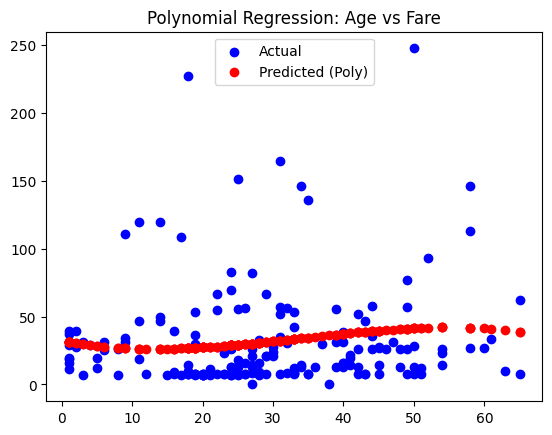

In [18]:
plt.scatter(X1_test, y1_test, color='blue', label='Actual')
plt.scatter(X1_test, y_pred_poly, color='red', label='Predicted (Poly)')
plt.legend()
plt.title("Polynomial Regression: Age vs Fare")
plt.show()

In [21]:
def report(name, y_true, y_pred):
    print(f"{name} R²: {r2_score(y_true, y_pred):.3f}")
    print(f"{name} RMSE: {root_mean_squared_error(y_true, y_pred):.2f}")  # Removed squared=False
    print(f"{name} MAE: {mean_absolute_error(y_true, y_pred):.2f}\n")

report("Linear", y1_test, y_pred_test1)
report("Ridge", y1_test, y_pred_ridge)
report("ElasticNet", y1_test, y_pred_elastic)
report("Polynomial", y1_test, y_pred_poly)

Linear R²: 0.005
Linear RMSE: 37.93
Linear MAE: 24.98

Ridge R²: 0.005
Ridge RMSE: 37.93
Ridge MAE: 24.98

ElasticNet R²: 0.006
ElasticNet RMSE: 37.93
ElasticNet MAE: 24.98

Polynomial R²: 0.003
Polynomial RMSE: 37.98
Polynomial MAE: 25.00



## 5.5 Visualize Higher Order Polynomial (for the same 1 input case)

Use the same single input case as you visualized above, but use a higher degree polynomial (e.g. 4, 5, 6, 7, or 8). Plot the result. 

In a Markdown cell, tell us which option seems to work better - your initial cubic (3) or your higher order and why. 